# Modelo 1 Árvore de Decisão

## 1. Importação de Bibliotecas

Finalidade Importa todas as dependências necessárias para:

* Manipulação de dados (Pandas, NumPy)

* Visualização (Matplotlib, Seaborn)

* NLP (NLTK, WordCloud)

* Machine Learning (Scikit-learn)

* Balanceamento de dados (SMOTE)

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

## 2. Configuração Inicial
Funções:

* Baixa stopwords em português

* Define estilo visual dos gráficos

In [ ]:

# Baixar stopwords em português
nltk.download('stopwords')

# Configurações visuais
plt.style.use('ggplot')
sns.set_palette('pastel')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Função de Carregamento de Dados

Etapas Principais:

1.   Combina múltiplos CSVs em um único DataFrame
2.   Limpa nomes das colunas com regex
3.  Identifica automaticamente a coluna de satisfação
4. Cria coluna binária Satisfacao_atual

Key Feature:

Tratamento inteligente de diferentes padrões de nomes de coluna

In [ ]:

def carregar_dados(paths: list) -> pd.DataFrame:
    """Carrega e combina múltiplos arquivos CSV (aqui só um arquivo)"""
    dados_combinados = pd.DataFrame()
    for path in paths:
        dados = pd.read_csv(path)
        dados.columns = [re.sub(r"\(\s*'([^']+)'\s*,.*", r'\1', col).strip()
                         for col in dados.columns]
        dados_combinados = pd.concat([dados_combinados, dados], ignore_index=True)

    satis_cols = [c for c in dados_combinados.columns if c.startswith("P2_k")]
    if not satis_cols:
        raise KeyError("Coluna de satisfação (P2_k...) não encontrada no dataset.")
    col_satisf = satis_cols[0]
    print(f"Coluna de satisfação detectada: '{col_satisf}'")

    dados_combinados["Satisfacao_atual"] = (
        dados_combinados[col_satisf]
        .map({1.0: 1, 0.0: 0})
        .fillna(0)
        .astype(int)
    )

    return dados_combinados


## 4. Análise Exploratória

Visualizações Geradas:

Distribuição da variável target (Satisfação)

Distribuição salarial (se presente nos dados)

Insights:

Mostra desbalanceamento de classes

Revela padrões demográficos na amostra



In [ ]:


def analise_exploratoria(dados: pd.DataFrame):
    """Visualizações básicas para entender os dados"""
    plt.figure(figsize=(8,5))
    ax = sns.countplot(x='Satisfacao_atual', data=dados)
    plt.title('Distribuição da Satisfação')
    plt.xlabel('Satisfação (0=Insatisfeito, 1=Satisfeito)')
    plt.ylabel('Contagem')
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0,5), textcoords='offset points')
    plt.show()

    if 'P2_h' in dados.columns:
        plt.figure(figsize=(12,6))
        ordem = dados['P2_h'].value_counts().index
        sns.countplot(y='P2_h', data=dados, order=ordem)
        plt.title('Distribuição por Faixa Salarial (P2_h)')
        plt.xlabel('Contagem')
        plt.ylabel('Faixa Salarial')
        plt.tight_layout()
        plt.show()


## 5. Pré-processamento

Fluxo de Trabalho:

Seleciona features preditivas

Trata valores faltantes

Aplica Label Encoding em todas as features

Retorna matrizes X e y prontas para modelagem

Atenção:

Conversão direta para string garante tratamento uniforme

In [ ]:
# Na função preprocessamento, adicione o retorno do dicionário variaveis
def preprocessamento(dados: pd.DataFrame):
    """Prepara as features e o target para modelagem"""
    variaveis = {
        "P1_a": "Idade",
        "P1_b": "Idade", # Possível duplicata, verificar no dataset real
        "P1_c": "Cor/Raça/Etnia",
        "P1_d": "PCD",
        "P1_l": "Nivel de Ensino",
        "P2_a": "Qual sua Situação de Trabalho",
        "P2_b": "Setor",
        "P2_c": "Numero de Funcionarios",
        "P2_d": "Gestor",
        "P2_f": "Cargo Atual",
        "P2_g": "Nivel",
        "P2_h": "Faixa Salarial",
        "P2_i": "Tempo na area de dados",
        "P2_j": "Tempo na area de TI e software",
        "P2_r": "Forma de Trabalho Atual",
        "P2_s": "Forma de Trababalho ideal",
        "P3_a": "Pessoas que Trabalham com Dados", # Pode ser texto, verificar
        "P4_d_1": "Novos Talentos",
        "P4_d_3": "Empresa Atual Investir em Dados",
        "P4_h_1": "Azure",
        "P4_h_2": "AWS",
        "P4_h_3": "GCP",
        "P4_j_1": "Bl", # Possível typo, verificar
        "P4_j_3": "Tableu", # Possível typo, verificar
        "P4_m_1": "IA Generativa",
        "P4_m_2": "IA Generativa Gratis",
        "P4_m_3": "IA Generativa Paga",
        "P4_m_5": "Copílote", # Possível typo, verificar
     }

    # Usa as chaves do dicionário para filtrar as colunas
    disponiveis = [chave for chave in variaveis.keys() if chave in dados.columns]

    if not disponiveis:
        raise ValueError("Nenhuma das variáveis de features está presente no DataFrame.")
    print(f'Usando {len(disponiveis)} features para modelagem.')

    X = dados[disponiveis].fillna('Não informado')
    y = dados['Satisfacao_atual']

    for col in X.columns:
        X[col] = X[col].astype(str)
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    # Retorna X, y e o dicionário variaveis
    return X, y, variaveis

## 6. Modelagem Preditiva

Arquitetura do Modelo:

* Pipeline com SMOTE para balanceamento

* Decision Tree com parâmetros controlados

* Métricas de avaliação:

* Classification Report

* Matriz de Confusão

* Curva ROC

* Feature Importance

Vantagens:

1. Combate ao overfitting com max_depth=5

2. Balanceamento duplo (SMOTE + class_weight)

In [ ]:
# Modifique a função treinar_modelo para aceitar o dicionário variaveis
def treinar_modelo(X, y, variaveis):
    """Treina o modelo Decision Tree com SMOTE para balanceamento e plota a importância das features com nomes descritivos"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    modelo = make_pipeline(
        SMOTE(random_state=42),
        DecisionTreeClassifier(
            max_depth=5, # Mantendo max_depth=5 como na primeira versão
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42
        )
    )

    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.show()

    y_prob = modelo.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

    importancias = modelo.named_steps['decisiontreeclassifier'].feature_importances_

    # Obtenha os nomes originais das features do X_train (que ainda são os códigos)
    original_feature_names = X_train.columns.tolist()

    indices = np.argsort(importancias)[::-1][:15]

    # Mapeie os códigos das features para os nomes descritivos usando o dicionário variaveis
    descriptive_feature_names = [variaveis.get(original_feature_names[i], original_feature_names[i]) for i in indices]


    plt.figure(figsize=(10,6))
    # Use descriptive_feature_names para o y-axis
    sns.barplot(x=importancias[indices], y=descriptive_feature_names)
    plt.title('Top 15 Features por Importância')
    plt.tight_layout()
    plt.show()


    return modelo, X_train, y_train # Retorna X_train, y_train para a curva de aprendizado

## 7. Validação Avançada
Técnicas Utilizadas:

* Validação cruzada 5-fold

* Curva de aprendizado

* Análise de variância de acurácia

In [ ]:


def avaliacao_avancada(modelo, X, y):
    """Validação cruzada e curva de aprendizado"""
    scores = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')
    print(f'Acurácia média (5-fold CV): {scores.mean():.3f} ± {scores.std():.3f}')

    train_sizes, train_scores, test_scores = learning_curve(
        modelo, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Treino')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validação')
    plt.xlabel('Tamanho do conjunto de treino')
    plt.ylabel('Acurácia')
    plt.title('Curva de Aprendizado')
    plt.legend()
    plt.show()

## 8. Análise de Texto com Word Clouds

Metodologia:

* Usa TF-IDF para identificar termos relevantes

* Gera visualizações diferenciadas por classe

* Salva imagens das nuvens de palavras

Insights Potenciais:

* Identifica padrões lexicais nos motivos de satisfação/insatisfação

In [ ]:


def gerar_nuvem_palavras(dados: pd.DataFrame, coluna_texto: str, condicao: int, titulo: str, nome_arquivo: str):
    """Gera uma nuvem de palavras para uma determinada condição de satisfação"""
    if coluna_texto not in dados.columns:
        print(f"Coluna '{coluna_texto}' não encontrada.")
        return

    respostas = dados[dados["Satisfacao_atual"] == condicao][coluna_texto].dropna().astype(str)
    if respostas.empty:
        print("Nenhuma resposta disponível para gerar a nuvem.")
        return

    stopwords_pt = stopwords.words('portuguese')
    vectorizer = TfidfVectorizer(stop_words=stopwords_pt, max_features=100)
    X_tfidf = vectorizer.fit_transform(respostas)
    word_importance = dict(zip(vectorizer.get_feature_names_out(), X_tfidf.sum(axis=0).A1))

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_importance)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.savefig(nome_arquivo)
    plt.show()

## 9. Fluxo Principal



Coluna de satisfação detectada: 'P2_k'


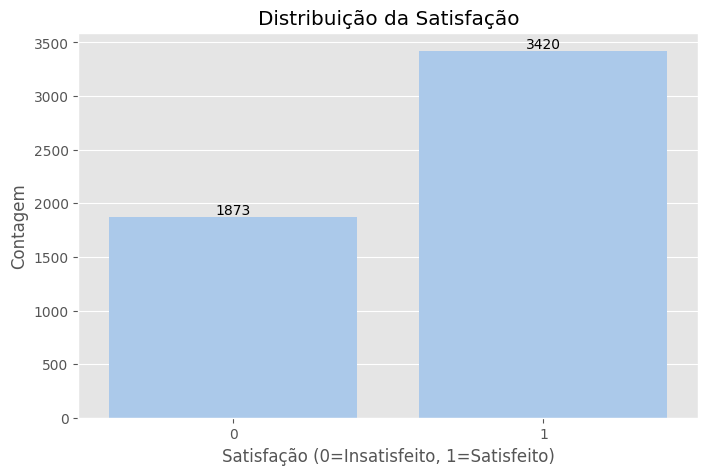

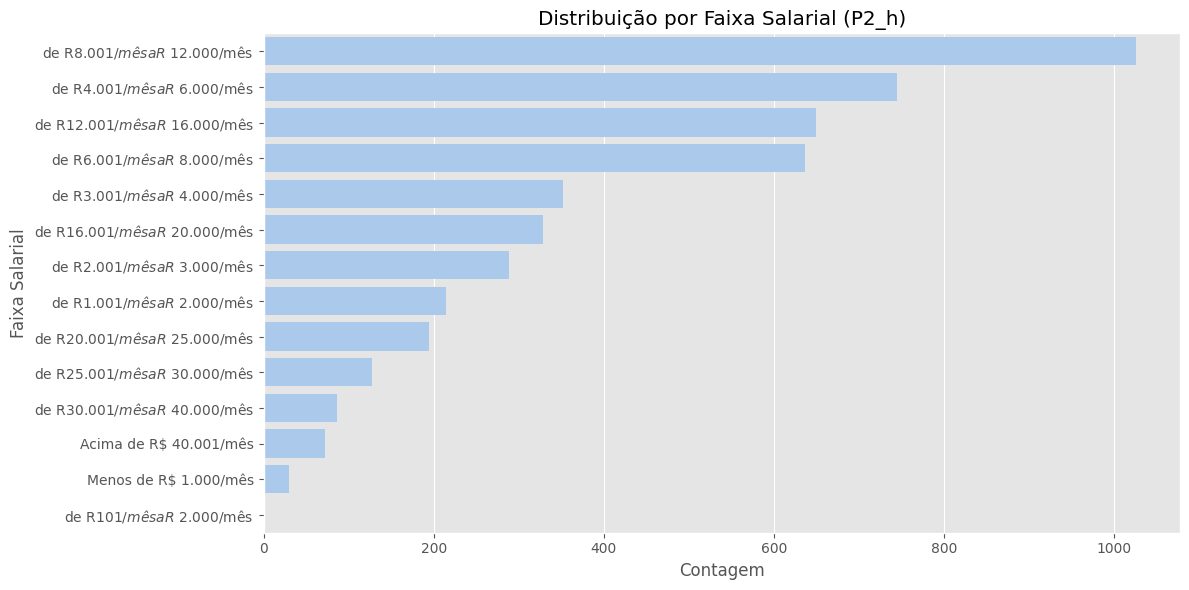

Usando 28 features para modelagem.

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.65      0.49      0.55       469
           1       0.75      0.85      0.80       855

    accuracy                           0.72      1324
   macro avg       0.70      0.67      0.68      1324
weighted avg       0.71      0.72      0.71      1324



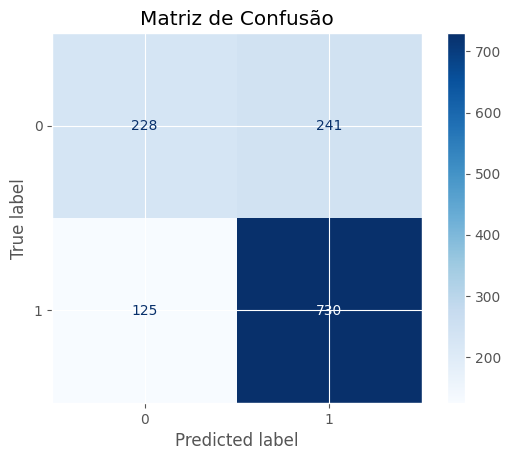

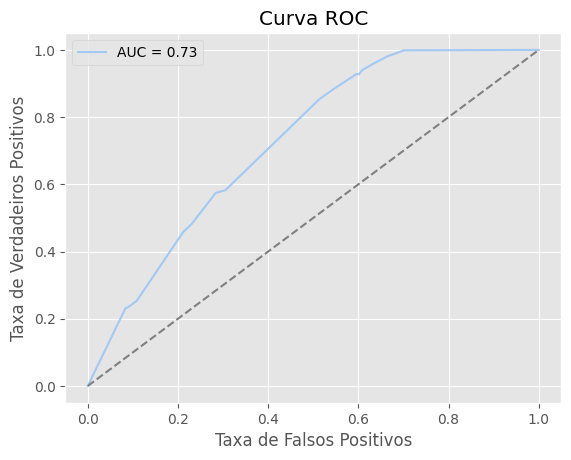

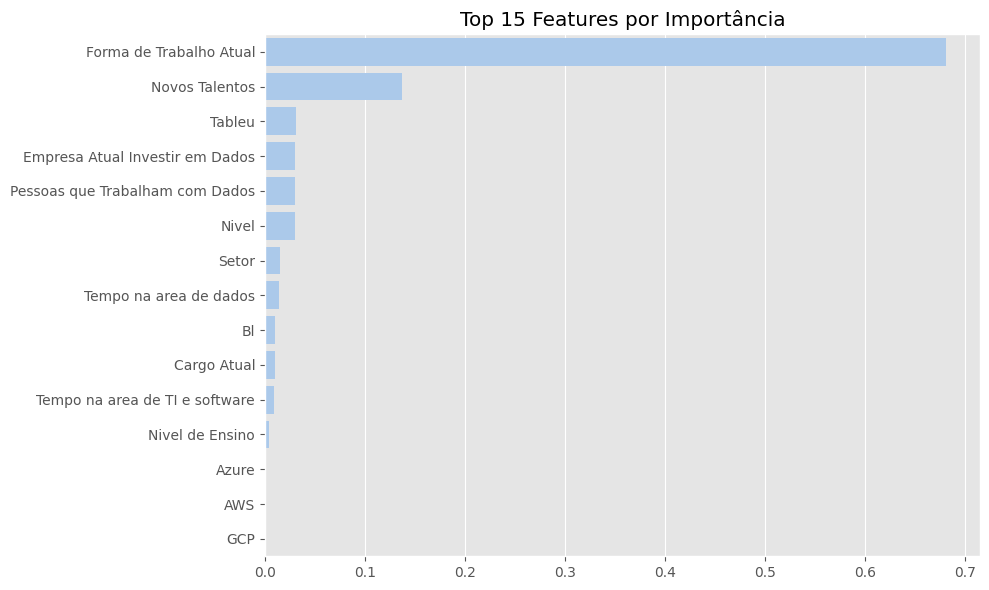

Acurácia média (5-fold CV): 0.698 ± 0.031


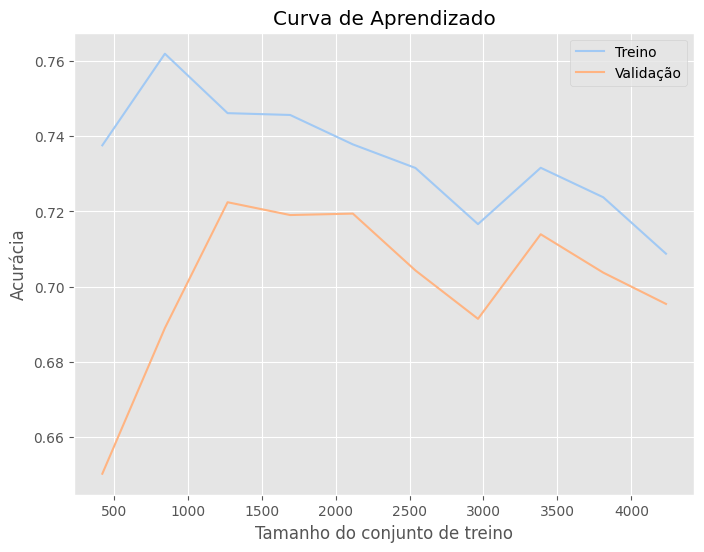

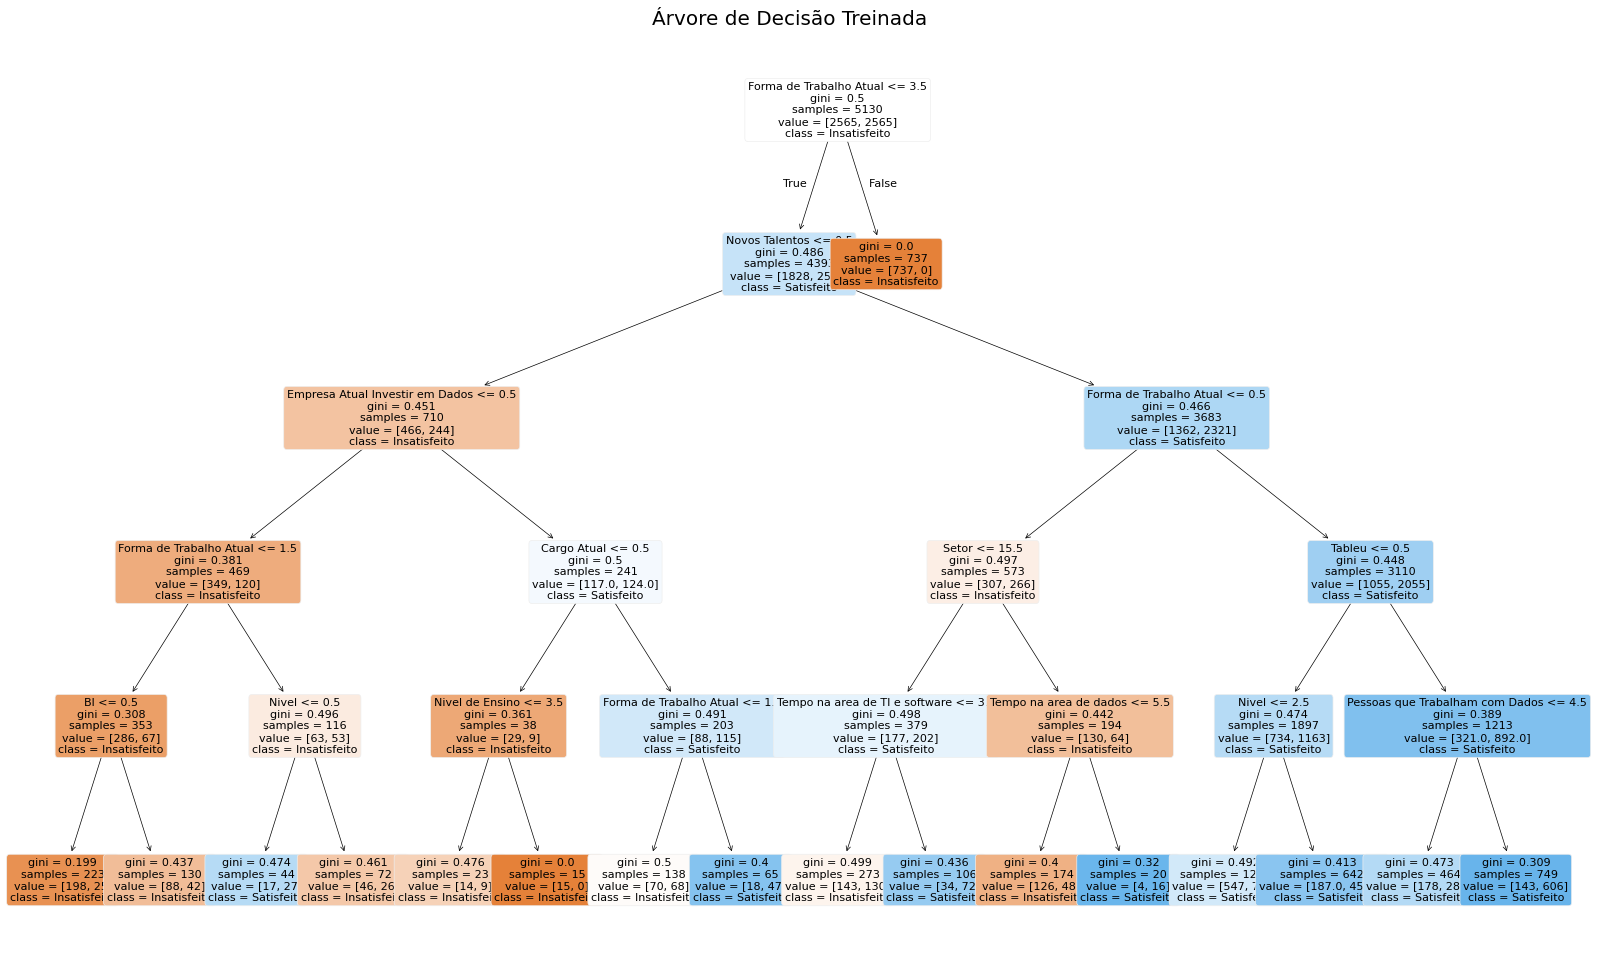

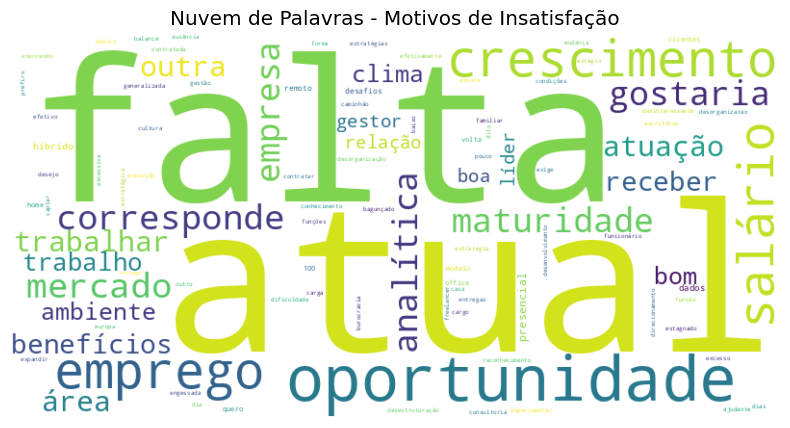

Nenhuma resposta disponível para gerar a nuvem.


In [ ]:

# Modifique a chamada das funções no main
def main():
    arquivos = [
        "State_of_data_BR_2023_Kaggle - df_survey_2023.csv"
    ]

    try:
        dados = carregar_dados(arquivos)
        analise_exploratoria(dados)
        # preprocessamento agora retorna X, y e variaveis
        X, y, variaveis = preprocessamento(dados)
        # Passe variaveis para treinar_modelo
        modelo, X_train_used_for_split, y_train_used_for_split = treinar_modelo(X, y, variaveis)

        # Passamos X e y completos para a validação cruzada e curva de aprendizado
        # pois learning_curve e cross_val_score fazem seus próprios splits
        avaliacao_avancada(modelo, X, y)


        plt.figure(figsize=(20,12))
        plot_tree(
            modelo.named_steps['decisiontreeclassifier'],
            # Usar os nomes descritivos para plotar a árvore
            feature_names=[variaveis.get(col, col) for col in X.columns],
            class_names=['Insatisfeito', 'Satisfeito'],
            filled=True,
            rounded=True,
            fontsize=8
        )
        plt.title("Árvore de Decisão Treinada")
        plt.show()

        # Geração das nuvens de palavras
        # Assumindo que 'P2_l' é a coluna de texto para comentários
        gerar_nuvem_palavras(
            dados, coluna_texto='P2_l', condicao=0,
            titulo='Nuvem de Palavras - Motivos de Insatisfação',
            nome_arquivo='wordcloud_insatisfacao.png'
        )

        gerar_nuvem_palavras(
            dados, coluna_texto='P2_l', condicao=1,
            titulo='Nuvem de Palavras - Motivos de Satisfação',
            nome_arquivo='wordcloud_satisfacao.png'
        )

    except Exception as e:
        print(f'\nErro: {e}')
        print('Verifique:')
        print('- Caminho do arquivo CSV')
        print('- Consistência das colunas')
        print('- Dados faltantes críticos')
        # Adicione um traceback mais detalhado para debugging se necessário
        # import traceback
        # traceback.print_exc()


if __name__ == "__main__":
    main()

## Mesmo modelo mais sem limitação

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Coluna de satisfação detectada: 'P2_k'


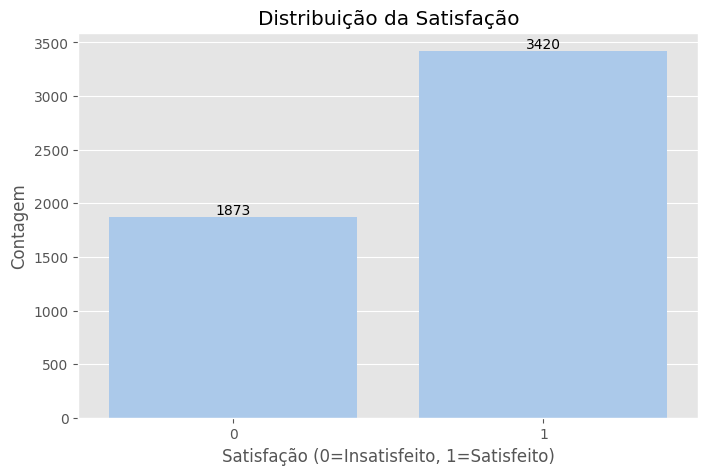

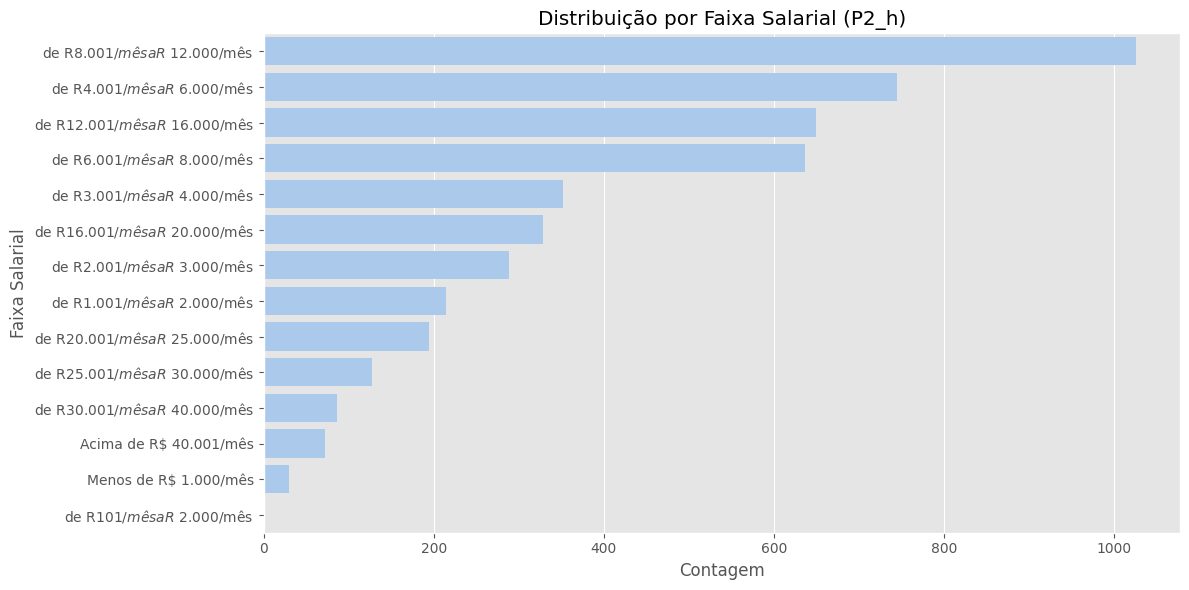

Usando 28 features para modelagem.

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.55      0.64      0.59       469
           1       0.78      0.71      0.74       855

    accuracy                           0.68      1324
   macro avg       0.66      0.67      0.67      1324
weighted avg       0.70      0.68      0.69      1324



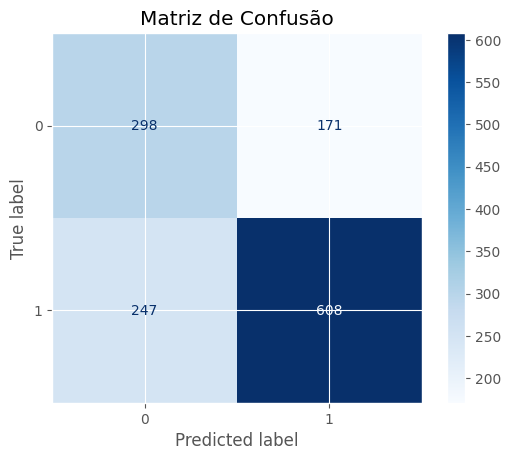

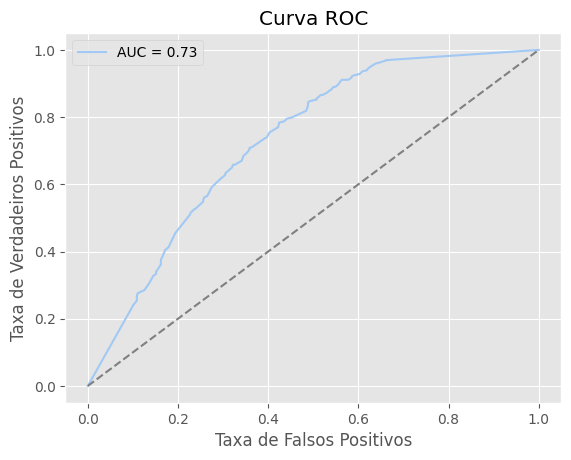

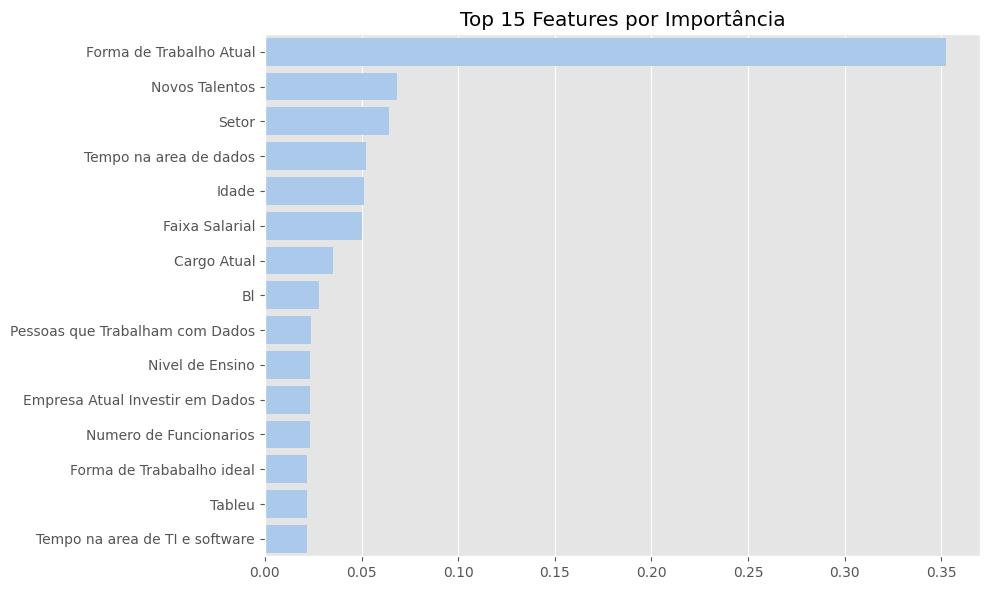

Acurácia média (5-fold Stratified CV): 0.659 ± 0.012
Gerando Curva de Aprendizado (usando dados de treino para o split interno da curva)...


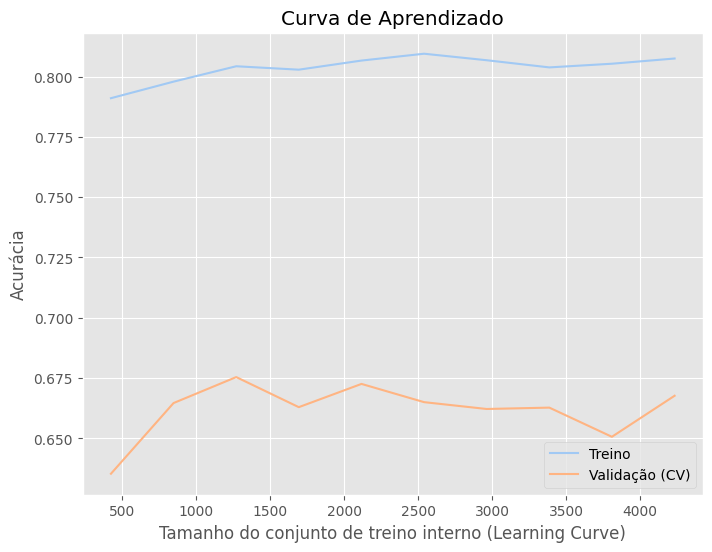

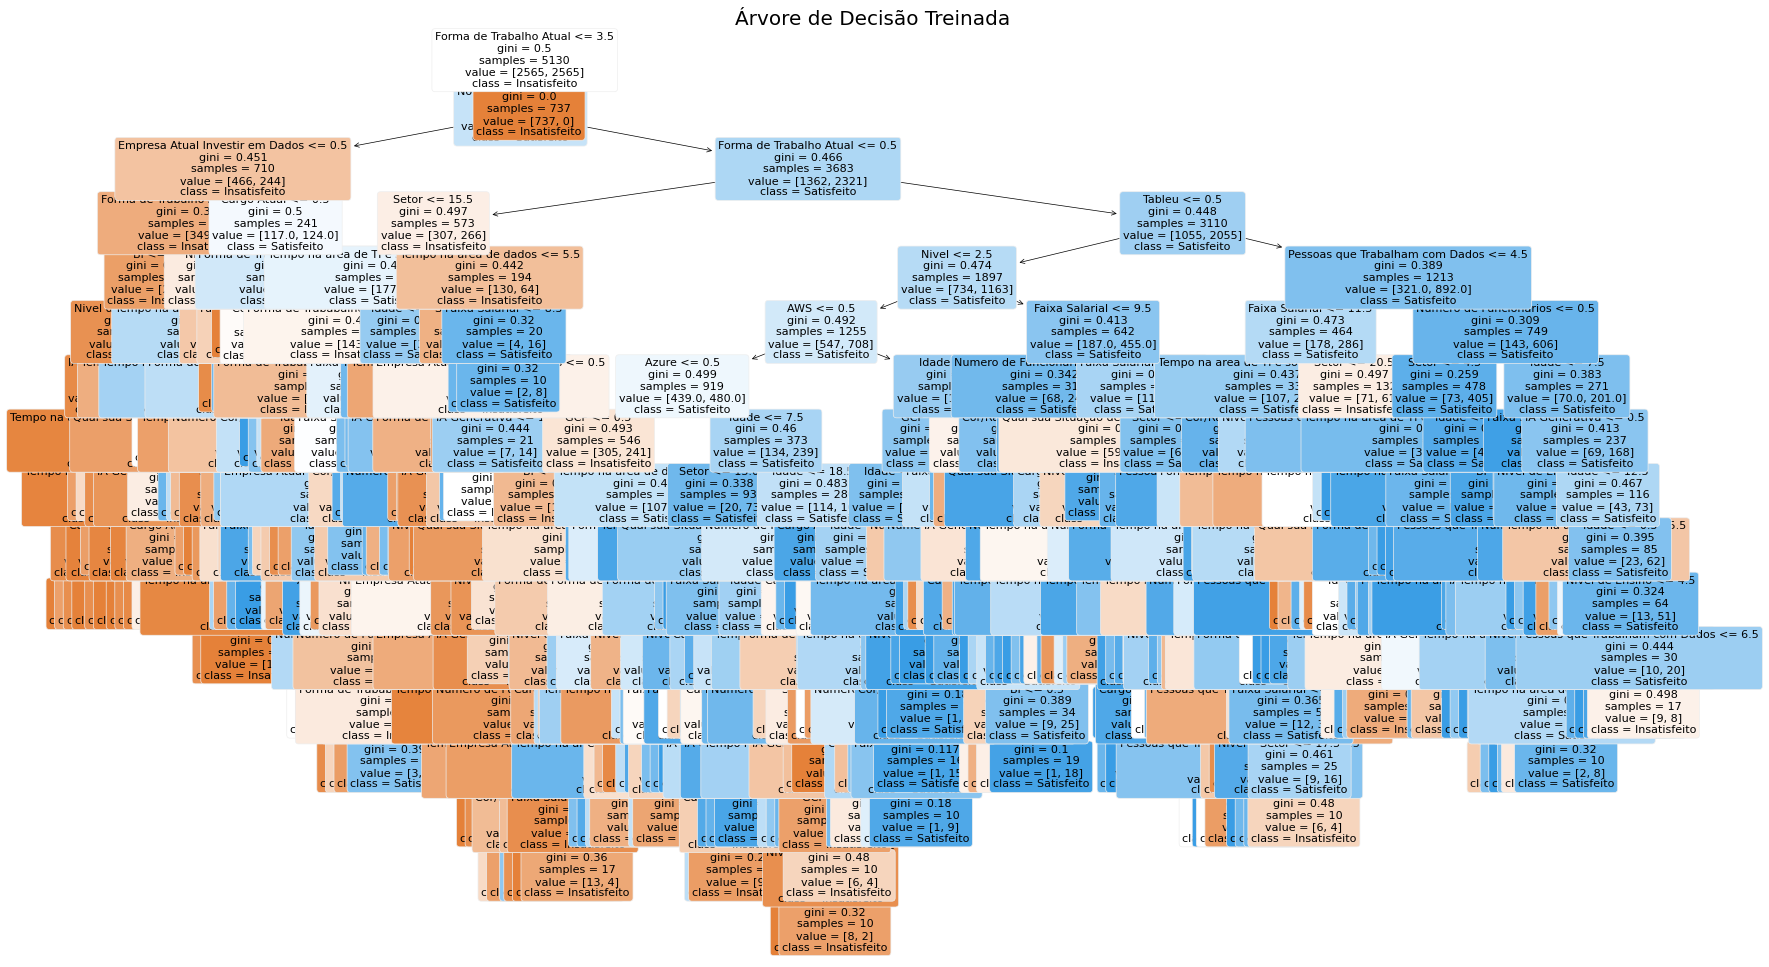

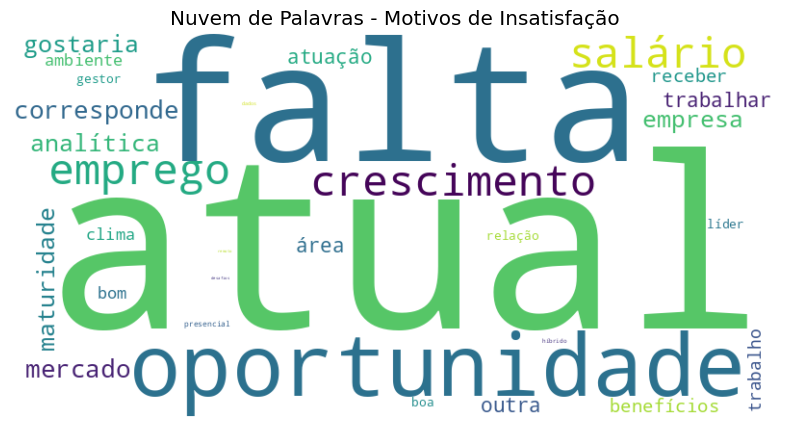

Nenhuma resposta disponível para gerar a nuvem.


In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Configuração Inicial
# Baixar stopwords em português
nltk.download('stopwords')

# Configurações visuais
plt.style.use('ggplot')
sns.set_palette('pastel')

# Função de Carregamento de Dados
def carregar_dados(paths: list) -> pd.DataFrame:
    """Carrega e combina múltiplos arquivos CSV (aqui só um arquivo)"""
    dados_combinados = pd.DataFrame()
    for path in paths:
        dados = pd.read_csv(path)
        dados.columns = [re.sub(r"\(\s*'([^']+)'\s*,.*", r'\1', col).strip()
                         for col in dados.columns]
        dados_combinados = pd.concat([dados_combinados, dados], ignore_index=True)

    satis_cols = [c for c in dados_combinados.columns if c.startswith("P2_k")]
    if not satis_cols:
        raise KeyError("Coluna de satisfação (P2_k...) não encontrada no dataset.")
    col_satisf = satis_cols[0]
    print(f"Coluna de satisfação detectada: '{col_satisf}'")

    dados_combinados["Satisfacao_atual"] = (
        dados_combinados[col_satisf]
        .map({1.0: 1, 0.0: 0})
        .fillna(0)
        .astype(int)
    )

    return dados_combinados

# Análise Exploratória
def analise_exploratoria(dados: pd.DataFrame):
    """Visualizações básicas para entender os dados"""
    plt.figure(figsize=(8,5))
    ax = sns.countplot(x='Satisfacao_atual', data=dados)
    plt.title('Distribuição da Satisfação')
    plt.xlabel('Satisfação (0=Insatisfeito, 1=Satisfeito)')
    plt.ylabel('Contagem')
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0,5), textcoords='offset points')
    plt.show()

    if 'P2_h' in dados.columns:
        plt.figure(figsize=(12,6))
        ordem = dados['P2_h'].value_counts().index
        sns.countplot(y='P2_h', data=dados, order=ordem)
        plt.title('Distribuição por Faixa Salarial (P2_h)')
        plt.xlabel('Contagem')
        plt.ylabel('Faixa Salarial')
        plt.tight_layout()
        plt.show()

# Pré-processamento
# Na função preprocessamento, adicione o retorno do dicionário variaveis
def preprocessamento(dados: pd.DataFrame):
    """Prepara as features e o target para modelagem"""
    variaveis = {
        "P1_a": "Idade",
        "P1_b": "Idade", # Possível duplicata, verificar no dataset real
        "P1_c": "Cor/Raça/Etnia",
        "P1_d": "PCD",
        "P1_l": "Nivel de Ensino",
        "P2_a": "Qual sua Situação de Trabalho",
        "P2_b": "Setor",
        "P2_c": "Numero de Funcionarios",
        "P2_d": "Gestor",
        "P2_f": "Cargo Atual",
        "P2_g": "Nivel",
        "P2_h": "Faixa Salarial",
        "P2_i": "Tempo na area de dados",
        "P2_j": "Tempo na area de TI e software",
        "P2_r": "Forma de Trabalho Atual",
        "P2_s": "Forma de Trababalho ideal",
        "P3_a": "Pessoas que Trabalham com Dados", # Pode ser texto, verificar
        "P4_d_1": "Novos Talentos",
        "P4_d_3": "Empresa Atual Investir em Dados",
        "P4_h_1": "Azure",
        "P4_h_2": "AWS",
        "P4_h_3": "GCP",
        "P4_j_1": "Bl", # Possível typo, verificar
        "P4_j_3": "Tableu", # Possível typo, verificar
        "P4_m_1": "IA Generativa",
        "P4_m_2": "IA Generativa Gratis",
        "P4_m_3": "IA Generativa Paga",
        "P4_m_5": "Copílote", # Possível typo, verificar
     }

    # Usa as chaves do dicionário para filtrar as colunas
    disponiveis = [chave for chave in variaveis.keys() if chave in dados.columns]

    if not disponiveis:
        raise ValueError("Nenhuma das variáveis de features está presente no DataFrame.")
    print(f'Usando {len(disponiveis)} features para modelagem.')

    X = dados[disponiveis].fillna('Não informado')
    y = dados['Satisfacao_atual']

    for col in X.columns:
        X[col] = X[col].astype(str)
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    # Retorna X, y e o dicionário variaveis
    return X, y, variaveis

# Modelagem Preditiva (Versão com split para métricas e plot)
# Modifique a função treinar_modelo para aceitar o dicionário variaveis
def treinar_modelo(X, y, variaveis):
    """Treina o modelo Decision Tree com SMOTE para balanceamento e plota a importância das features com nomes descritivos"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    modelo = make_pipeline(
        SMOTE(random_state=42),
        DecisionTreeClassifier(
            # Removido max_depth=5 para permitir crescimento máximo
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42
        )
    )

    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.show()

    y_prob = modelo.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

    importancias = modelo.named_steps['decisiontreeclassifier'].feature_importances_
    # Obtenha os nomes originais das features do X_train (que ainda são os códigos)
    original_feature_names = X_train.columns.tolist()

    indices = np.argsort(importancias)[::-1][:15]
    # Mapeie os códigos das features para os nomes descritivos usando o dicionário variaveis
    descriptive_feature_names = [variaveis.get(original_feature_names[i], original_feature_names[i]) for i in indices]


    plt.figure(figsize=(10,6))
    # Use descriptive_feature_names para o y-axis
    sns.barplot(x=importancias[indices], y=descriptive_feature_names)
    plt.title('Top 15 Features por Importância')
    plt.tight_layout()
    plt.show()


    return modelo, X_train, y_train # Retorna X_train, y_train para a curva de aprendizado

# Validação Avançada
def avaliacao_avancada(modelo, X, y):
    """Validação cruzada e curva de aprendizado"""
    # Usando StratifiedKFold para manter a proporção da classe target na validação cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(modelo, X, y, cv=cv, scoring='accuracy', n_jobs=-1) # Usando o modelo (pipeline) diretamente
    print(f'Acurácia média (5-fold Stratified CV): {scores.mean():.3f} ± {scores.std():.3f}')

    # A curva de aprendizado deve ser feita no conjunto de treino usado no treinamento
    # Portanto, precisamos passar X_train e y_train para esta função
    # (Atualização: a função treinar_modelo já retorna X_train e y_train,
    #  vamos ajustar a chamada em main para passá-los)
    print("Gerando Curva de Aprendizado (usando dados de treino para o split interno da curva)...")
    train_sizes, train_scores, test_scores = learning_curve(
        modelo, X, y, cv=cv, n_jobs=-1, # Usando o pipeline e o conjunto COMPLETO para a curva
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Treino')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validação (CV)')
    plt.xlabel('Tamanho do conjunto de treino interno (Learning Curve)')
    plt.ylabel('Acurácia')
    plt.title('Curva de Aprendizado')
    plt.legend()
    plt.show()


# Análise de Texto com Word Clouds
def gerar_nuvem_palavras(dados: pd.DataFrame, coluna_texto: str, condicao: int, titulo: str, nome_arquivo: str):
    """Gera uma nuvem de palavras para uma determinada condição de satisfação"""
    if coluna_texto not in dados.columns:
        print(f"Coluna '{coluna_texto}' não encontrada.")
        return

    respostas = dados[dados["Satisfacao_atual"] == condicao][coluna_texto].dropna().astype(str)
    if respostas.empty:
        print("Nenhuma resposta disponível para gerar a nuvem.")
        return

    # Certifique-se que a lista de stopwords foi baixada
    try:
        stopwords_pt = stopwords.words('portuguese')
    except LookupError:
        nltk.download('stopwords')
        stopwords_pt = stopwords.words('portuguese')

    # Ajustar TF-IDF para usar o vocabulário do conjunto de respostas
    vectorizer = TfidfVectorizer(stop_words=stopwords_pt, max_features=100)
    X_tfidf = vectorizer.fit_transform(respostas)
    word_importance = dict(zip(vectorizer.get_feature_names_out(), X_tfidf.sum(axis=0).A1))

    # Se houver palavras com importância zero (acontece com max_features), remova-as
    word_importance = {word: score for word, score in word_importance.items() if score > 0}
    if not word_importance:
         print("Nenhuma palavra com importância > 0 encontrada para gerar a nuvem.")
         return


    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_importance)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.savefig(nome_arquivo)
    plt.show()

# Fluxo Principal
# Modifique a chamada das funções no main
def main():
    arquivos = [
        "State_of_data_BR_2023_Kaggle - df_survey_2023.csv"
    ]

    try:
        dados = carregar_dados(arquivos)
        analise_exploratoria(dados)
        # preprocessamento agora retorna X, y e variaveis
        X, y, variaveis = preprocessamento(dados)
        # Passe variaveis para treinar_modelo
        modelo, X_train_used_for_split, y_train_used_for_split = treinar_modelo(X, y, variaveis)

        # Passamos X e y completos para a validação cruzada e curva de aprendizado
        # pois learning_curve e cross_val_score fazem seus próprios splits
        avaliacao_avancada(modelo, X, y)


        plt.figure(figsize=(20,12))
        plot_tree(
            modelo.named_steps['decisiontreeclassifier'],
            # Usar os nomes descritivos para plotar a árvore
            feature_names=[variaveis.get(col, col) for col in X.columns],
            class_names=['Insatisfeito', 'Satisfeito'],
            filled=True,
            rounded=True,
            fontsize=8
        )
        plt.title("Árvore de Decisão Treinada")
        plt.show()

        # Geração das nuvens de palavras
        # Assumindo que 'P2_l' é a coluna de texto para comentários
        gerar_nuvem_palavras(
            dados, coluna_texto='P2_l', condicao=0,
            titulo='Nuvem de Palavras - Motivos de Insatisfação',
            nome_arquivo='wordcloud_insatisfacao.png'
        )

        gerar_nuvem_palavras(
            dados, coluna_texto='P2_l', condicao=1,
            titulo='Nuvem de Palavras - Motivos de Satisfação',
            nome_arquivo='wordcloud_satisfacao.png'
        )

    except Exception as e:
        print(f'\nErro: {e}')
        print('Verifique:')
        print('- Caminho do arquivo CSV')
        print('- Consistência das colunas')
        print('- Dados faltantes críticos')
        # Adicione um traceback mais detalhado para debugging se necessário
        # import traceback
        # traceback.print_exc()


if __name__ == "__main__":
    main()